In [262]:
import sys
sys.path.append('../')

try:
    from ..spn_simulator.components.spn import *
    from ..spn_simulator.components.spn_visualization import *
    from ..spn_simulator.components.spn_simulate import *
    from ..spn_simulator.components.spn_io import *
except:
    from spn_simulator.components.spn import *
    from spn_simulator.components.spn_visualization import *
    from spn_simulator.components.spn_simulate import *
    from spn_simulator.components.spn_io import *

import pandas as pd
import pm4py



In [263]:
event_log = pd.read_csv ('raw_data/event_log.csv', sep=";", converters={"order_id":str})
state_log = pd.read_csv ('raw_data/state_log.csv', sep=";")
event_log['timestamp'] = event_log['timestamp'].str.replace('CET|CEST', '', regex=True)
event_log['timestamp'] = pd.to_datetime(event_log['timestamp']).dt.tz_localize('Europe/Berlin')

In [264]:
event_log.head()

,timestamp,order_id,resource,event
0,2023-04-18 00:00:00+02:00,260,MES,new_order
1,2023-04-18 00:00:00+02:00,260,cell1,cell1_operation
2,2023-04-18 00:00:01+02:00,260,cell2,cell2_operation
3,2023-04-18 00:00:01+02:00,261,MES,new_order
4,2023-04-18 00:00:01+02:00,261,cell1,cell1_operation


In [265]:
state_log.head()

,timestamp,resource,state
0,Tue Apr 18 00:00:00 CEST 2023,cell1,busy
1,Tue Apr 18 00:00:01 CEST 2023,cell1,idle
2,Tue Apr 18 00:00:01 CEST 2023,cell2,busy
3,Tue Apr 18 00:00:01 CEST 2023,cell1,busy
4,Tue Apr 18 00:00:02 CEST 2023,cell2,idle


In [266]:
net, im, fm = pm4py.discover_petri_net_alpha(event_log, activity_key='event', case_id_key='order_id', timestamp_key='timestamp')

In [267]:
#net, im, fm = pm4py.discover_petri_net_inductive(event_log, activity_key='event', case_id_key='order_id', timestamp_key='timestamp', noise_threshold = 0.1)

In [268]:
net

places: [ ({'cell1_operation'}, {'cell2_operation'}), ({'cell2_operation'}, {'order_completed'}), ({'new_order'}, {'cell1_operation'}), end, start ]
transitions: [ (cell1_operation, 'cell1_operation'), (cell2_operation, 'cell2_operation'), (new_order, 'new_order'), (order_completed, 'order_completed') ]
arcs: [ (cell1_operation, 'cell1_operation')->({'cell1_operation'}, {'cell2_operation'}), (cell2_operation, 'cell2_operation')->({'cell2_operation'}, {'order_completed'}), (new_order, 'new_order')->({'new_order'}, {'cell1_operation'}), (order_completed, 'order_completed')->end, ({'cell1_operation'}, {'cell2_operation'})->(cell2_operation, 'cell2_operation'), ({'cell2_operation'}, {'order_completed'})->(order_completed, 'order_completed'), ({'new_order'}, {'cell1_operation'})->(cell1_operation, 'cell1_operation'), start->(new_order, 'new_order') ]

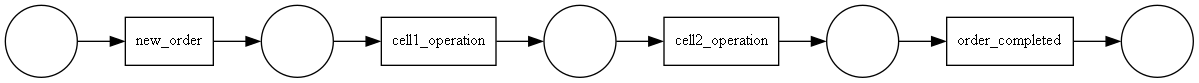

In [269]:
pm4py.view_petri_net(net)

({'new_order'}, {'cell1_operation'})
({'cell2_operation'}, {'order_completed'})
({'cell1_operation'}, {'cell2_operation'})


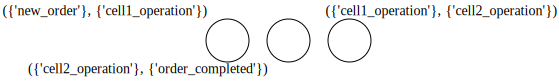

In [270]:
spn = SPN()

for place in net.places:
    if "start" not in str(place) and "end" not in str(place):
        print(place)
        new_place = Place(label=str(place), n_tokens=0)
        spn.add_place(new_place)

draw_spn(spn, show=False)

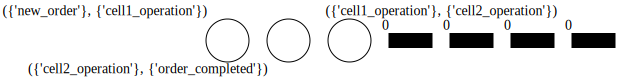

In [271]:
for transition in net.transitions:
    new_transition = Transition(label=str(transition),t_type="I")
    print(new_transition)
    spn.add_transition(new_transition)

draw_spn(spn, show=False)

In [261]:
for arc in net.arcs:
    if arc.source is in 
    print(arc.source)

start
(order_completed, 'order_completed')
(cell1_operation, 'cell1_operation')
(cell2_operation, 'cell2_operation')
({'cell1_operation'}, {'cell2_operation'})
({'cell2_operation'}, {'order_completed'})
(new_order, 'new_order')
({'new_order'}, {'cell1_operation'})


In [226]:
net.transitions

{(cell1_operation, 'cell1_operation'),
 (cell2_operation, 'cell2_operation'),
 (new_order, 'new_order'),
 (order_completed, 'order_completed')}

In [201]:
net.places

{({'cell1_operation'}, {'cell2_operation'}),
 ({'cell2_operation'}, {'order_completed'}),
 ({'new_order'}, {'cell1_operation'}),
 end,
 start}

In [237]:
list(net.arcs)[1].target

({'cell2_operation'}, {'order_completed'})

In [200]:
for arc in net.arcs:
    if str(arc.source) != "start" and str(arc.target) != "end":
        print(arc.source.name)
        print(arc.target.name)

cell2_operation
({'cell2_operation'}, {'order_completed'})
cell1_operation
({'cell1_operation'}, {'cell2_operation'})
({'cell1_operation'}, {'cell2_operation'})
cell2_operation
({'cell2_operation'}, {'order_completed'})
order_completed
new_order
({'new_order'}, {'cell1_operation'})
({'new_order'}, {'cell1_operation'})
cell1_operation
